# Установка файлов и библиотек

In [1]:
!pip install pmdarima
!pip install numpy==1.26.4
!pip install keras-tuner

from pmdarima import auto_arima
import warnings
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from io import BytesIO
from datetime import datetime
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
from statsmodels.tsa.stattools import acf, pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout



warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Загрузка файла для тстирования модели
url_test = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/test.xlsx"
response = requests.get(url_test)
df_test = pd.read_excel(BytesIO(response.content), engine='openpyxl')

# Загрузка основного df
url1 = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"
response1 = requests.get(url1)
df1 = pd.read_excel(BytesIO(response1.content), engine='openpyxl')

# Загрузка третьего файла
df2 = pd.read_excel('/content/Макропоказатели_final.xlsx')
df2 = df2.fillna(method='ffill')

# Анализ и предобработка

### просмотр статистической информации

In [3]:
print("Информация о первом DataFrame (train):")
df1.info()
print("_________________________________________________________")
df1.head()

Информация о первом DataFrame (train):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB
_________________________________________________________


,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300


In [4]:
print("\nИнформация о втором DataFrame (Макропоказатели):")
df2.info()
print("___________________________________________________________________________________________________")
df2.head()


Информация о втором DataFrame (Макропоказатели):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063 entries, 0 to 2062
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   dt                                                     2063 non-null   datetime64[ns]
 1   Базовый индекс потребительских цен на товары и услуги  2063 non-null   float64       
 2   Ключевая ставка                                        2063 non-null   float64       
 3   Курс доллара                                           2063 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 64.6 KB
___________________________________________________________________________________________________


,dt,Базовый индекс потребительских цен на товары и услуги,Ключевая ставка,Курс доллара
0,2023-06-16,100.370000,7.5,83.9611
1,2023-06-15,100.741369,7.5,84.3249
2,2023-06-14,101.114112,7.5,83.6405
3,2023-06-13,101.488234,7.5,82.6417
4,2023-06-10,101.863741,7.5,82.6417


In [5]:
# Объединение по колонке 'dt'
df_ts = pd.merge(df1, df2,  on='dt', how='left')

# Вывод результата
print("\nОбъединенный DataFrame:")
df_ts.info()
print("________________________________________________________________________________________________________________________________________")
df_ts.head()

df_ts.to_excel('Объединенный DataFrame.xlsx', index=False)


Объединенный DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   dt                                                     400 non-null    datetime64[ns]
 1   Цена на арматуру                                       400 non-null    int64         
 2   Базовый индекс потребительских цен на товары и услуги  286 non-null    float64       
 3   Ключевая ставка                                        286 non-null    float64       
 4   Курс доллара                                           286 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 15.8 KB
________________________________________________________________________________________________________________________________________


In [6]:

# import xml.etree.ElementTree as ET

# # Загрузка данных из Excel
# file_path = '/content/Объединенный DataFrame.xlsx'
# df_ts = pd.read_excel(file_path)

# # Преобразование столбца с датами
# df_ts['dt'] = pd.to_datetime(df_ts['dt'], format='%Y-%m-%d %H:%M:%S')

# # Данные об индексах потребительских цен (ИПЦ) по месяцам
# ipc_data = {
#     "2015-01": 103.85, "2015-02": 102.22, "2015-03": 101.21, "2015-04": 100.46, "2015-05": 100.35,
#     "2015-06": 100.19, "2015-07": 100.80, "2015-08": 100.35, "2015-09": 100.57, "2015-10": 100.74,
#     "2015-11": 100.75, "2015-12": 100.77, "2016-01": 100.96, "2016-02": 100.63, "2016-03": 100.46,
#     "2016-04": 100.44, "2016-05": 100.41, "2016-06": 100.36, "2016-07": 100.54, "2016-08": 100.01,
#     "2016-09": 100.17, "2016-10": 100.43, "2016-11": 100.44, "2016-12": 100.40, "2017-01": 100.62,
#     "2017-02": 100.22, "2017-03": 100.13, "2017-04": 100.33, "2017-05": 100.37, "2017-06": 100.61,
#     "2017-07": 100.07, "2017-08": 99.46, "2017-09": 99.85, "2017-10": 100.20, "2017-11": 100.22,
#     "2017-12": 100.42, "2018-01": 100.31, "2018-02": 100.21, "2018-03": 100.29, "2018-04": 100.38,
#     "2018-05": 100.38, "2018-06": 100.49, "2018-07": 100.27, "2018-08": 100.01, "2018-09": 100.16,
#     "2018-10": 100.35, "2018-11": 100.50, "2018-12": 100.84, "2019-01": 101.01, "2019-02": 100.44,
#     "2019-03": 100.32, "2019-04": 100.29, "2019-05": 100.34, "2019-06": 100.04, "2019-07": 100.20,
#     "2019-08": 99.76, "2019-09": 99.84, "2019-10": 100.13, "2019-11": 100.28, "2019-12": 100.36,
#     "2020-01": 100.40, "2020-02": 100.33, "2020-03": 100.55, "2020-04": 100.83, "2020-05": 100.27,
#     "2020-06": 100.22, "2020-07": 100.35, "2020-08": 99.96, "2020-09": 99.93, "2020-10": 100.43,
#     "2020-11": 100.71, "2020-12": 100.83, "2021-01": 100.67, "2021-02": 100.78, "2021-03": 100.66,
#     "2021-04": 100.58, "2021-05": 100.74, "2021-06": 100.69, "2021-07": 100.31, "2021-08": 100.17,
#     "2021-09": 100.60, "2021-10": 101.11, "2021-11": 100.96, "2021-12": 100.82, "2022-01": 100.99,
#     "2022-02": 101.17, "2022-03": 107.61, "2022-04": 101.56, "2022-05": 100.12, "2022-06": 99.65,
#     "2022-07": 99.61, "2022-08": 99.48, "2022-09": 100.05, "2022-10": 100.18, "2022-11": 100.37,
#     "2022-12": 100.78, "2023-01": 100.84, "2023-02": 100.46, "2023-03": 100.37, "2023-04": 100.38,
#     "2023-05": 100.31, "2023-06": 100.37,
# }

# # Добавляем колонку базового ИПЦ
# df_ts["Базовый индекс потребительских цен на товары и услуги"] = None

# # Заполняем колонку
# for i, row in df_ts.iterrows():
#     year_month = row['dt'].strftime("%Y-%m")
#     df_ts.at[i, "Базовый индекс потребительских цен на товары и услуги"] = ipc_data.get(year_month, 100)

# # Функция для получения курса доллара
# def get_usd_rate(date):
#     url = f'https://www.cbr.ru/scripts/XML_daily.asp?date_req={date.strftime("%d/%m/%Y")}'
#     response = requests.get(url)
#     if response.status_code == 200:
#         tree = ET.ElementTree(ET.fromstring(response.content))
#         for valute in tree.getroot().findall('Valute'):
#             if valute.find('CharCode').text == 'USD':
#                 return float(valute.find('Value').text.replace(',', '.'))
#     return None

# # Функция для получения ключевой ставки
# def get_key_rate(date):
#     url = 'https://www.cbr.ru/eng/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=05.01.2015&UniDbQuery.To=21.03.2025'
#     response = requests.get(url)
#     if response.status_code == 200:
#         soup = BeautifulSoup(response.content, 'html.parser')
#         table = soup.find('table', {'class': 'data'})
#         if table:
#             for row in table.find_all('tr')[1:]:
#                 cols = row.find_all('td')
#                 if len(cols) >= 2:
#                     rate_date = datetime.strptime(cols[0].text.strip(), '%d.%m.%Y')
#                     if rate_date <= date:
#                         return float(cols[1].text.replace(',', '.'))
#     return None

# # Заполняем недостающие данные
# for index, row in df_ts.iterrows():
#     if pd.isna(row['Курс доллара']):
#         df_ts.at[index, 'Курс доллара'] = get_usd_rate(row['dt'])
#     if pd.isna(row['Ключевая ставка']):
#         df_ts.at[index, 'Ключевая ставка'] = get_key_rate(row['dt'])

# # Сохранение файла
# df_ts.to_excel('/content/df_ts.xlsx', index=False)

In [7]:
df_ts = pd.read_excel('/content/df_ts.xlsx')
df_ts = df_ts.sort_values(by='dt', ascending=True)

In [8]:
print("\nОбъединенный DataFrame:")
df_ts.info()
print("________________________________________________________________________________________________________________________________________")
df_ts.head()



Объединенный DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   dt                                                     400 non-null    datetime64[ns]
 1   Цена на арматуру                                       400 non-null    int64         
 2   Базовый индекс потребительских цен на товары и услуги  400 non-null    float64       
 3   Ключевая ставка                                        400 non-null    float64       
 4   Курс доллара                                           400 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 15.8 KB
________________________________________________________________________________________________________________________________________


,dt,Цена на арматуру,Базовый индекс потребительских цен на товары и услуги,Ключевая ставка,Курс доллара
0,2015-01-05,32900,103.85,17.0,56.2376
1,2015-01-12,32500,103.85,17.0,56.2376
2,2015-01-19,32000,103.85,17.0,65.1738
3,2015-01-26,30700,103.85,17.0,63.3930
4,2015-02-02,30300,102.22,15.0,68.9291


In [9]:
# Проверка на наличие NaN
df_ts['dt'].isna().sum()

0

In [10]:
df_ts.describe()

,dt,Цена на арматуру,Базовый индекс потребительских цен на товары и услуги,Ключевая ставка,Курс доллара
count,400,400.000000,400.000000,400.000000,400.000000
mean,2018-11-01 12:00:00,39229.475000,100.534600,8.612500,66.149080
min,2015-01-05 00:00:00,21000.000000,99.460000,4.250000,49.790100
25%,2016-12-03 06:00:00,31075.000000,100.210000,6.750000,60.803825
50%,2018-11-01 12:00:00,35450.000000,100.380000,7.750000,65.094250
75%,2020-09-29 18:00:00,42000.000000,100.670000,10.500000,72.734725
max,2022-08-29 00:00:00,79000.000000,107.610000,20.000000,116.751700
std,NaN,13407.979668,0.888096,3.100524,7.878073


In [11]:
df_ts.shape

(400, 5)

### Визуализация

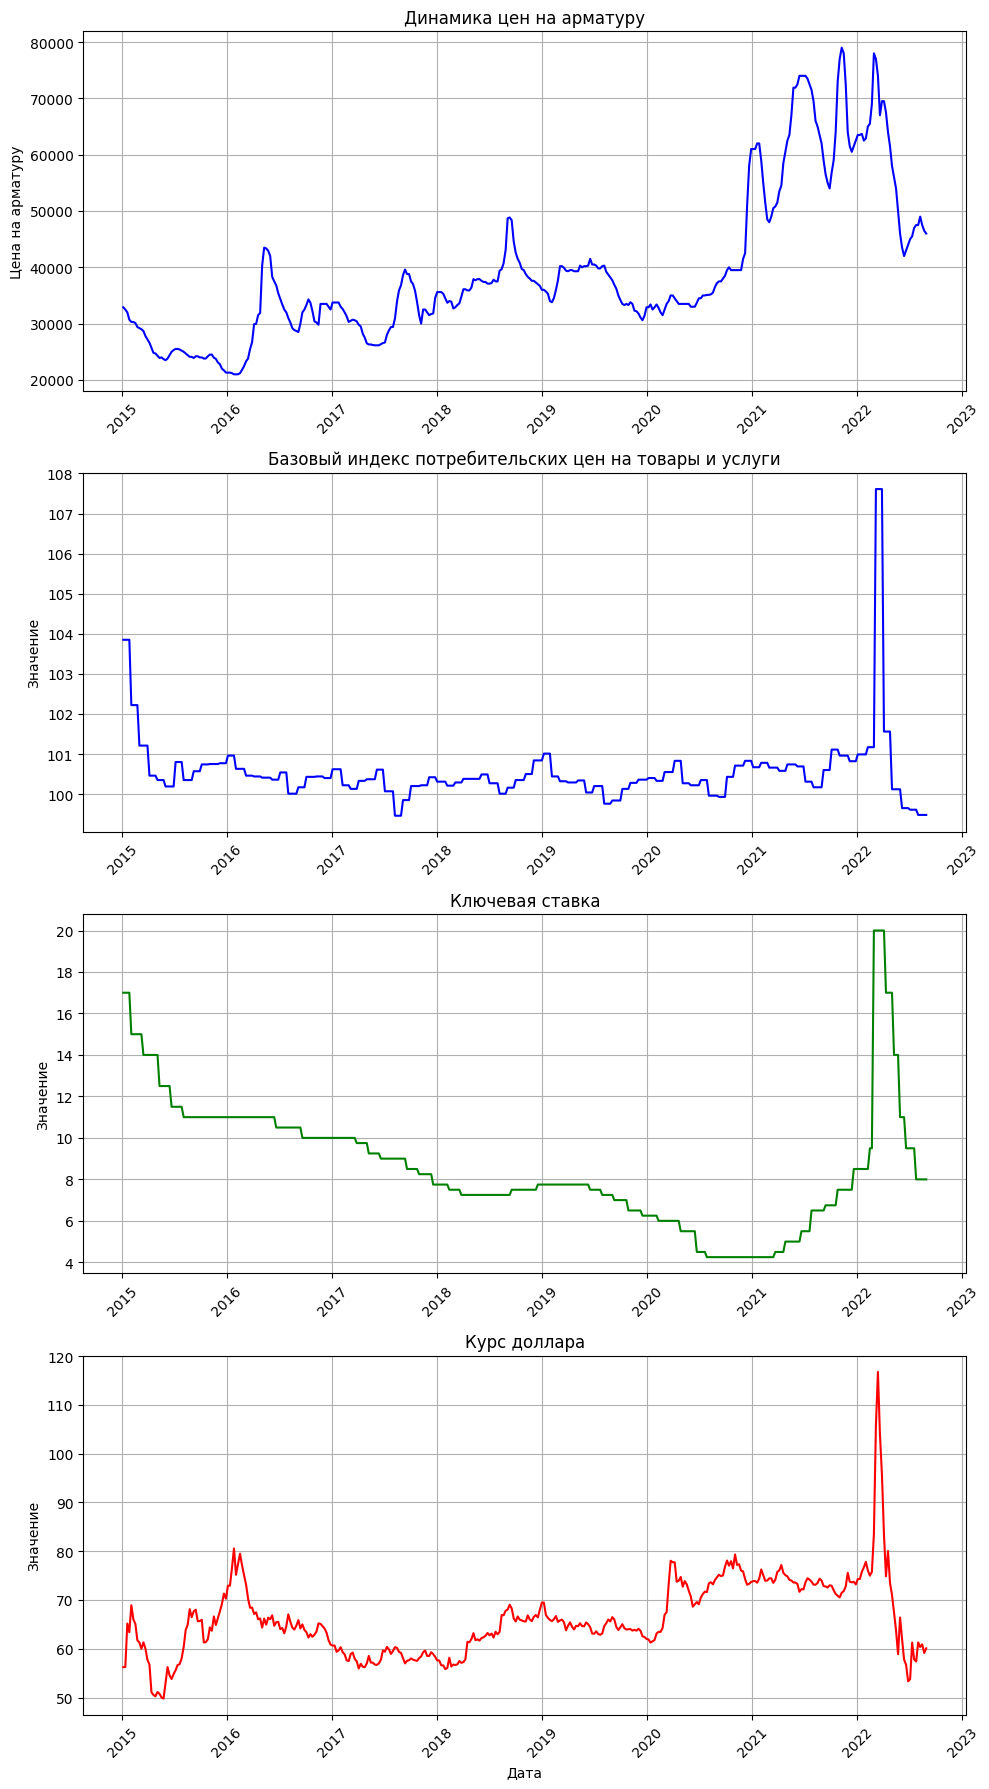

In [12]:
# Создаем фигуру и оси (3 графика в одном столбце)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 18))

# График 1: Цена на арматуру
axes[0].plot(df_ts['dt'], df_ts["Цена на арматуру"], marker='', linestyle='-', color='blue')
axes[0].set_title("Динамика цен на арматуру")
axes[0].set_ylabel("Цена на арматуру")
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# График 2: Базовый индекс потребительских цен
axes[1].plot(df_ts['dt'], df_ts["Базовый индекс потребительских цен на товары и услуги"], marker='', linestyle='-', color='blue')
axes[1].set_title("Базовый индекс потребительских цен на товары и услуги")
axes[1].set_ylabel("Значение")
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# График 3: Ключевая ставка
axes[2].plot(df_ts['dt'], df_ts["Ключевая ставка"], marker='', linestyle='-', color='green')
axes[2].set_title("Ключевая ставка")
axes[2].set_ylabel("Значение")
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=45)

# График 4: Курс доллара
axes[3].plot(df_ts['dt'], df_ts["Курс доллара"], marker='', linestyle='-', color='red')
axes[3].set_title("Курс доллара")
axes[3].set_xlabel("Дата")
axes[3].set_ylabel("Значение")
axes[3].grid(True)
axes[3].tick_params(axis='x', rotation=45)

# Улучшение компоновки
plt.tight_layout()

# Показ графиков
plt.show()

**Вопросы к графику:**

 1.Есть ли тренды?

 2.Есть ли сезонности?

 3.Насколько сильный шумы?



In [13]:
# Получил 'сырые' значения автокорреляций
acf(df_ts["Цена на арматуру"] ,nlags = 100, fft = False)

array([1.        , 0.99138242, 0.97367714, 0.95122039, 0.92740427,
       0.90357365, 0.88126621, 0.8606089 , 0.84235253, 0.82671727,
       0.81349611, 0.8020525 , 0.7925797 , 0.78508849, 0.78019657,
       0.77692922, 0.77376814, 0.76901294, 0.76227632, 0.75319077,
       0.74261145, 0.7309889 , 0.71862345, 0.7046383 , 0.68939965,
       0.67325908, 0.65612584, 0.63820561, 0.62109396, 0.60459259,
       0.58872289, 0.57435372, 0.56120831, 0.54900152, 0.5377084 ,
       0.5271632 , 0.51674918, 0.5068141 , 0.49691253, 0.48636205,
       0.47460061, 0.4600824 , 0.44257206, 0.42285538, 0.40223733,
       0.38033844, 0.35769402, 0.33517203, 0.31316745, 0.29306128,
       0.27522925, 0.2595102 , 0.24447201, 0.23086215, 0.21896621,
       0.20859445, 0.1993889 , 0.19088593, 0.18300826, 0.1757314 ,
       0.16880023, 0.16166525, 0.15350675, 0.14370082, 0.13267574,
       0.12198755, 0.11231837, 0.10288107, 0.0929827 , 0.08286002,
       0.07336018, 0.06476539, 0.05709237, 0.05068118, 0.04473

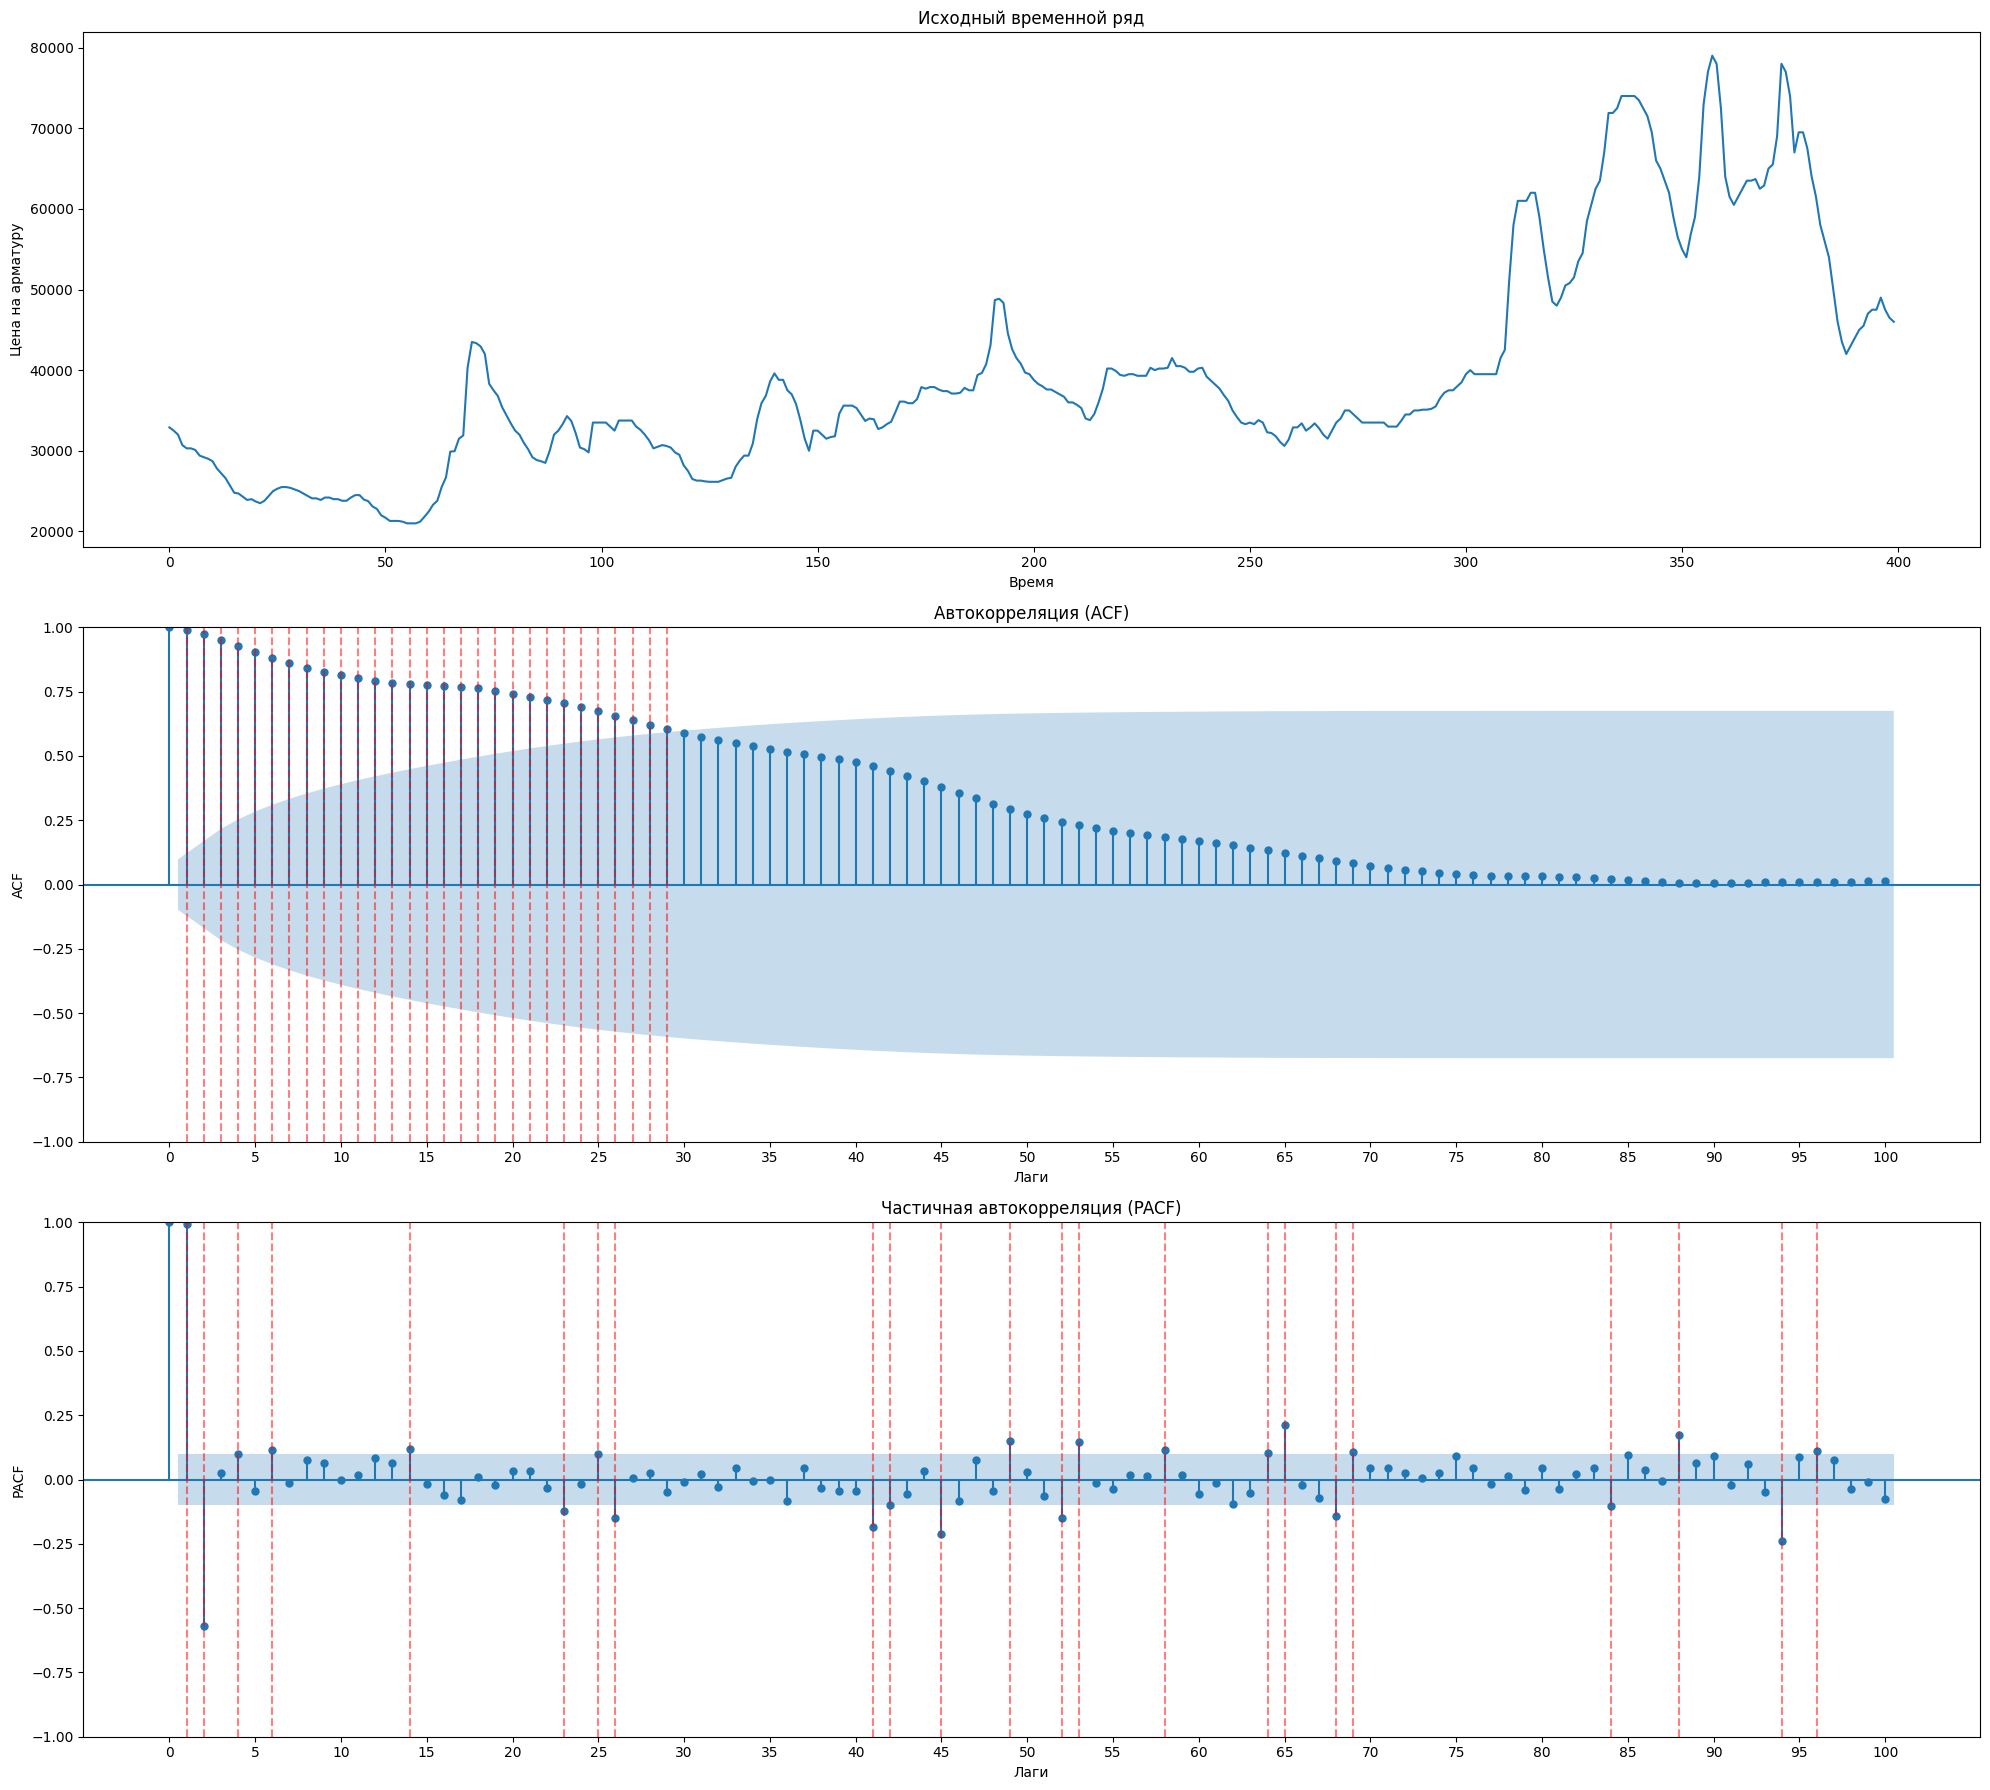

In [14]:
# Создаем график с тремя подграфиками
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 18))

# Первый подграфик: исходный временной ряд
df_ts['Цена на арматуру'].plot(ax=ax[0])
ax[0].set_title('Исходный временной ряд')
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Цена на арматуру')

# Второй подграфик: ACF (автокорреляция)
plot_acf(df_ts['Цена на арматуру'], lags=100, ax=ax[1], alpha=0.05)
ax[1].set_title('Автокорреляция (ACF)')
ax[1].set_xlabel('Лаги')
ax[1].set_ylabel('ACF')

# Получаем значения ACF и доверительные интервалы
acf_values, confint = acf(df_ts['Цена на арматуру'], nlags=100, alpha=0.05)

# Добавляем вертикальные линии для выбросов
for lag in range(1, len(acf_values)):  # Начинаем с 1, так как lag=0 всегда равен 1
    if abs(acf_values[lag]) > confint[lag, 1] - acf_values[lag]:  # Проверяем, выходит ли значение за пределы доверительного интервала
        ax[1].axvline(x=lag, color='red', linestyle='--', alpha=0.5)  # Добавляем вертикальную линию

# Убедимся, что на оси X отображаются все лаги
ax[1].set_xticks(np.arange(0, 101, 5))  # Отображаем каждые 5 лагов
ax[1].set_xticklabels(np.arange(0, 101, 5))  # Подписываем оси

# Третий подграфик: PACF (частичная автокорреляция)
plot_pacf(df_ts['Цена на арматуру'], lags=100, ax=ax[2], method='ols', alpha=0.05)
ax[2].set_title('Частичная автокорреляция (PACF)')
ax[2].set_xlabel('Лаги')
ax[2].set_ylabel('PACF')

# Получаем значения PACF и доверительные интервалы
pacf_values, confint = pacf(df_ts['Цена на арматуру'], nlags=100, method='ols', alpha=0.05)

# Добавляем вертикальные линии для выбросов
for lag in range(1, len(pacf_values)):  # Начинаем с 1, так как lag=0 всегда равен 1
    if abs(pacf_values[lag]) > confint[lag, 1] - pacf_values[lag]:  # Проверяем, выходит ли значение за пределы доверительного интервала
        ax[2].axvline(x=lag, color='red', linestyle='--', alpha=0.5)  # Добавляем вертикальную линию

# Убедимся, что на оси X отображаются все лаги
ax[2].set_xticks(np.arange(0, 101, 5))  # Отображаем каждые 5 лагов
ax[2].set_xticklabels(np.arange(0, 101, 5))  # Подписываем оси

# Отображаем график
plt.tight_layout()
plt.show()

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Функция анализа временного ряда и создания признаков
def analyze_and_create_features(df, columns, period=26, threshold_trend=0.05, threshold_seasonal=0.05):
    """
    Анализ временного ряда и создание новых признаков на основе тренда, сезонности и остатка.
    """
    df = df.interpolate(method='linear')  # Линейная интерполяция
    df = df.fillna(method='ffill').fillna(method='bfill')  # Заполнение крайних значений

    features = pd.DataFrame(index=df.index)

    for col in columns:
        print(f"\nАнализ временного ряда: {col}")

        if df[col].isna().sum() > 0:
            print(f"⚠ Внимание! В колонке {col} остались пропуски после интерполяции.")
            continue

        # Декомпозиция
        decomposition = seasonal_decompose(df[col], period=period, model='additive', extrapolate_trend=True)

        # Оценка значимости тренда и сезонности
        trend_missing_ratio = decomposition.trend.isna().mean()
        observed_std = np.nanstd(decomposition.observed)
        trend_std = np.nanstd(decomposition.trend) / observed_std if observed_std != 0 else 0
        seasonal_strength = 1 - (np.nanvar(decomposition.resid) / np.nanvar(decomposition.observed) if np.nanvar(decomposition.observed) != 0 else 1)

        use_trend = trend_missing_ratio < threshold_trend and trend_std > 0.1
        use_seasonal = seasonal_strength > threshold_seasonal

        print(f"  → Доля NaN в тренде: {trend_missing_ratio:.2f}")
        print(f"  → Отклонение тренда: {trend_std:.2f}")
        print(f"  → Сила сезонности: {seasonal_strength:.2f}")

        if use_trend:
            features[f"{col}_trend"] = decomposition.trend
            print(f"  ✅ Добавлен тренд {col}")

        if use_seasonal:
            features[f"{col}_seasonal"] = decomposition.seasonal
            print(f"  ✅ Добавлена сезонность {col}")

        features[f"{col}_residual"] = decomposition.resid
        print(f"  ✅ Добавлен остаток (шум) {col}")

    return features

# Загрузка данных
df_ts = pd.read_excel("df_ts.xlsx", parse_dates=["dt"])

# Улучшенное заполнение пропусков
df_ts = df_ts.interpolate(method='linear')
df_ts = df_ts.fillna(method='ffill').fillna(method='bfill')

columns_to_analyze = ["Цена на арматуру", "Базовый индекс потребительских цен на товары и услуги", "Ключевая ставка", "Курс доллара"]

# Создание признаков
features = analyze_and_create_features(df_ts, columns_to_analyze, period=26)

# Проверяем наличие столбцов и заполняем пропуски
for col in columns_to_analyze:
    for suffix in ["trend", "seasonal", "residual"]:
        col_name = f"{col}_{suffix}"
        if col_name in df_ts.columns:
            # Если колонка уже есть, заполняем пропуски
            df_ts[col_name].fillna(features[col_name], inplace=True)
            print(f"🔄 Заполнены пропуски в {col_name}")
        else:
            # Если колонки нет, добавляем ее
            df_ts[col_name] = features[col_name]
            print(f"✅ Добавлена новая колонка {col_name}")

# Сохранение результата
df_ts.to_excel("df_ts_ml.xlsx", index=True)

# Функция визуализации декомпозиции для нескольких колонок
def plot_multiple_decompositions(df, columns, period=26):
    """
    Визуализация декомпозиции для нескольких временных рядов.

    :param df: DataFrame с временными рядами.
    :param columns: Список колонок для анализа.
    :param period: Период сезонности.
    """
    for column in columns:
        if column not in df.columns:
            print(f"⚠ Колонка {column} отсутствует в данных, пропускаем.")
            continue

        if df[column].isna().sum() > 0:
            print(f"⚠ Пропуски в {column}, пропускаем визуализацию.")
            continue

        decompose = seasonal_decompose(df[column], period=period, model='additive', extrapolate_trend=True)

        fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 20))

        ax[0].plot(decompose.observed, color='blue')
        ax[0].set_title(f'Оригинальный ряд: {column}')
        ax[0].grid(True)

        ax[1].plot(decompose.trend, color='green')
        ax[1].set_title('Тренд')
        ax[1].grid(True)

        ax[2].plot(decompose.seasonal, color='orange')
        ax[2].set_title('Сезонность')
        ax[2].grid(True)

        ax[3].plot(decompose.resid, color='red')
        ax[3].set_title('Шум (остатки)')
        ax[3].set_xlabel("Дата")
        ax[3].grid(True)

        plt.tight_layout()
        plt.show()



# Создание DataFrame с компонентами (оптимизировано)
df_components = pd.DataFrame(index=df_ts.index)

for col in columns_to_analyze:
    if df_ts[col].isna().sum() > 0:
        print(f"⚠ Пропускаем {col}, так как есть NaN.")
        continue

    decomposition = seasonal_decompose(df_ts[col], period=26, model='additive', extrapolate_trend=True)
    df_components[f"{col}_trend"] = decomposition.trend
    df_components[f"{col}_seasonal"] = decomposition.seasonal
    df_components[f"{col}_residual"] = decomposition.resid

# Сохранение компонентов
df_components.to_csv("decomposed_components.csv")


Анализ временного ряда: Цена на арматуру
  → Доля NaN в тренде: 0.00
  → Отклонение тренда: 0.93
  → Сила сезонности: 0.90
  ✅ Добавлен тренд Цена на арматуру
  ✅ Добавлена сезонность Цена на арматуру
  ✅ Добавлен остаток (шум) Цена на арматуру

Анализ временного ряда: Базовый индекс потребительских цен на товары и услуги
  → Доля NaN в тренде: 0.00
  → Отклонение тренда: 0.55
  → Сила сезонности: 0.42
  ✅ Добавлен тренд Базовый индекс потребительских цен на товары и услуги
  ✅ Добавлена сезонность Базовый индекс потребительских цен на товары и услуги
  ✅ Добавлен остаток (шум) Базовый индекс потребительских цен на товары и услуги

Анализ временного ряда: Ключевая ставка
  → Доля NaN в тренде: 0.00
  → Отклонение тренда: 0.93
  → Сила сезонности: 0.85
  ✅ Добавлен тренд Ключевая ставка
  ✅ Добавлена сезонность Ключевая ставка
  ✅ Добавлен остаток (шум) Ключевая ставка

Анализ временного ряда: Курс доллара
  → Доля NaN в тренде: 0.00
  → Отклонение тренда: 0.80
  → Сила сезонности: 0.7

In [16]:
df_components.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Цена на арматуру_trend                                          400 non-null    float64
 1   Цена на арматуру_seasonal                                       400 non-null    float64
 2   Цена на арматуру_residual                                       400 non-null    float64
 3   Базовый индекс потребительских цен на товары и услуги_trend     400 non-null    float64
 4   Базовый индекс потребительских цен на товары и услуги_seasonal  400 non-null    float64
 5   Базовый индекс потребительских цен на товары и услуги_residual  400 non-null    float64
 6   Ключевая ставка_trend                                           400 non-null    float64
 7   Ключевая ставка_seasonal                             

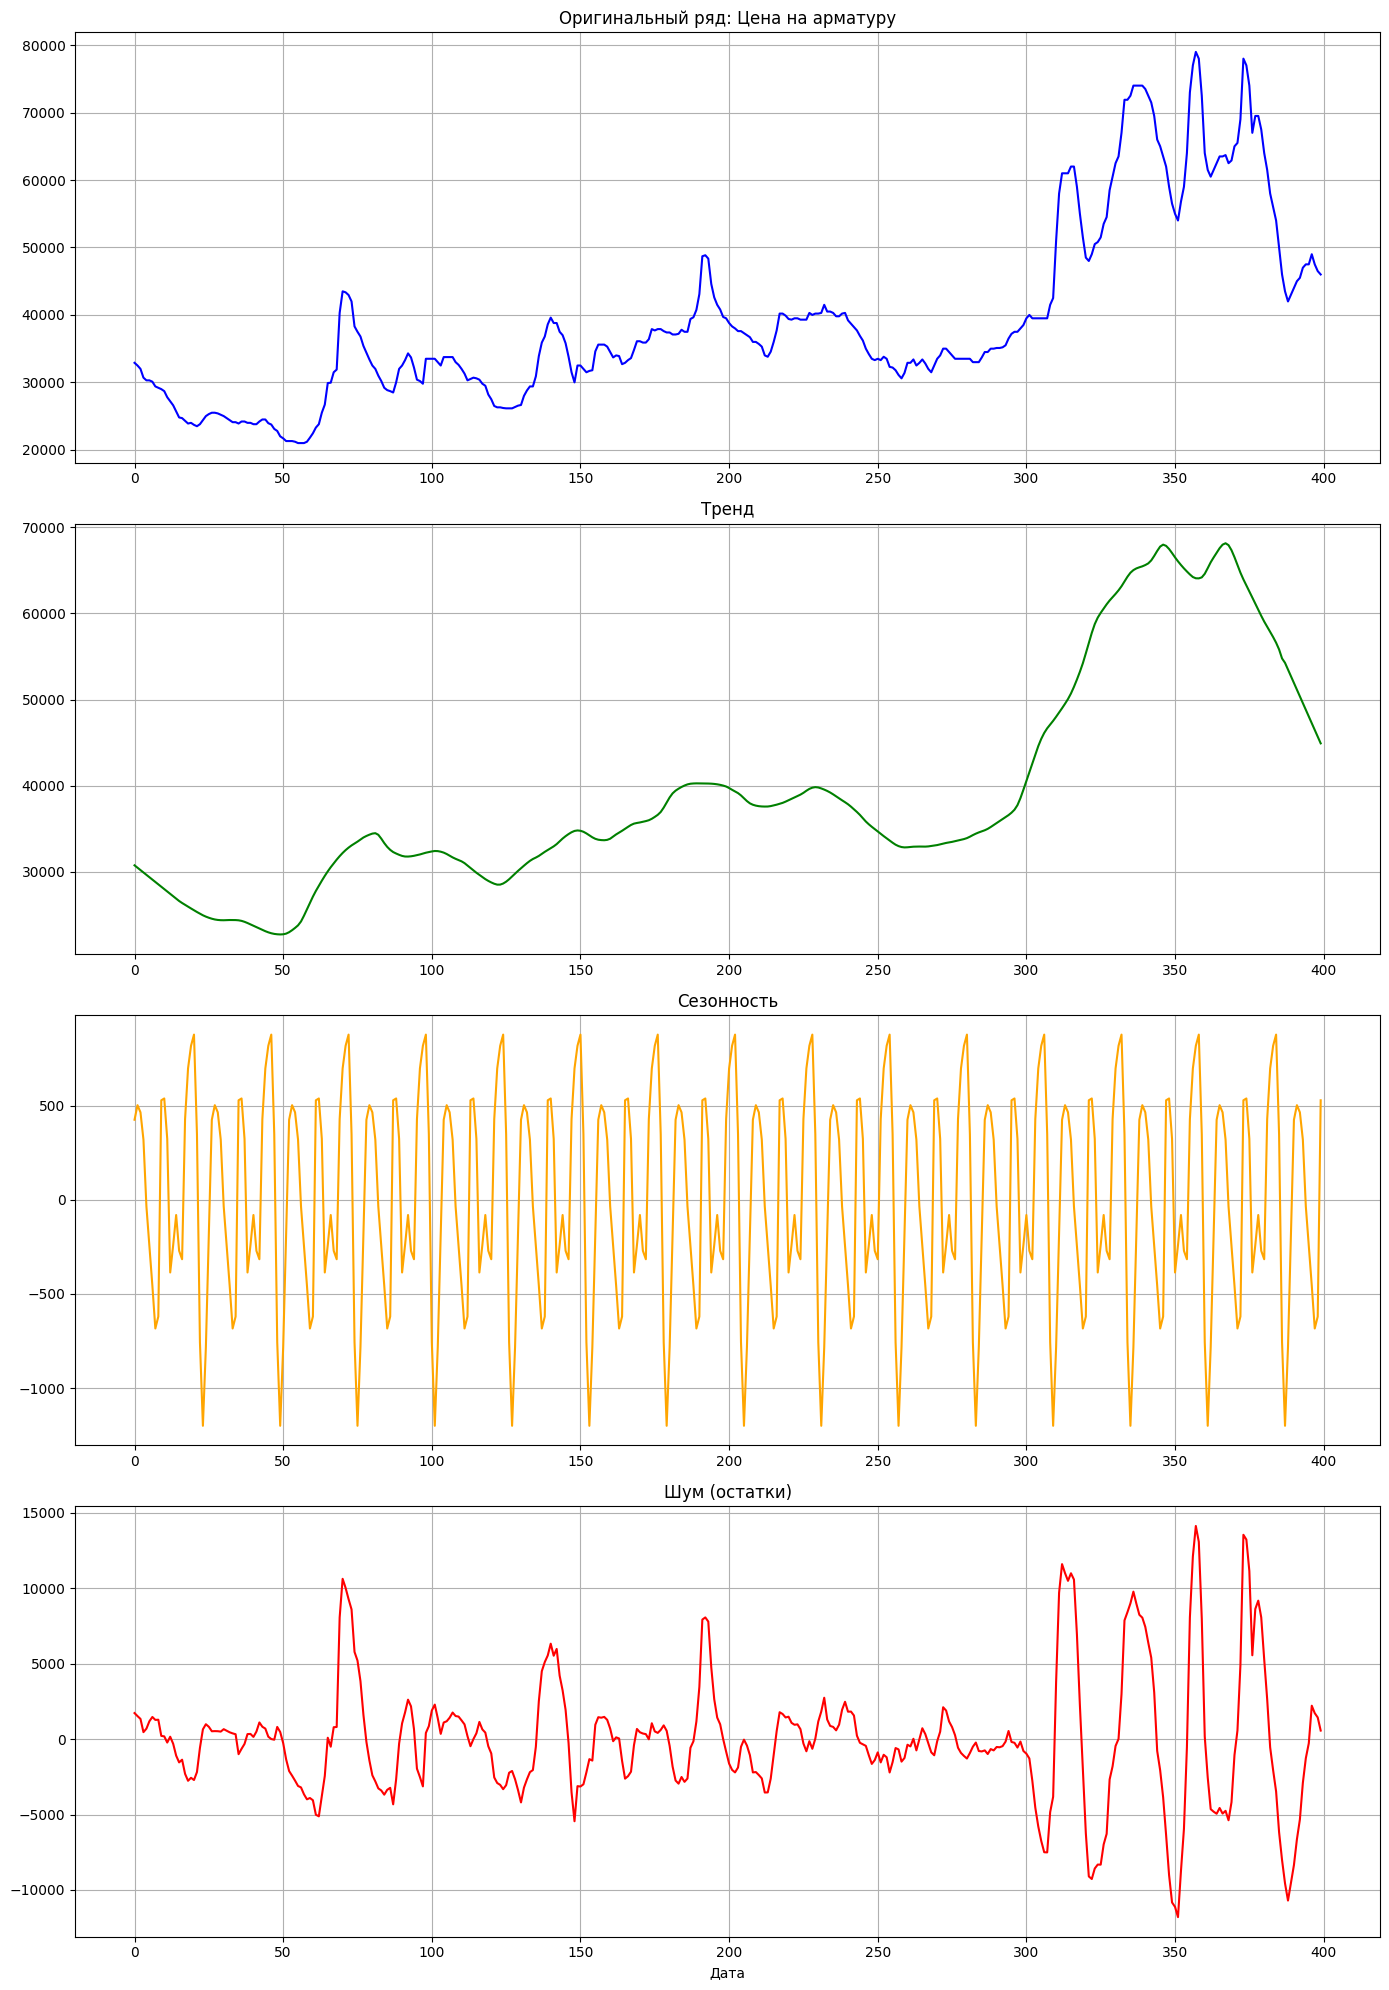

In [17]:
# Визуализация декомпозиции для выбранных переменных
selected_columns = ["Цена на арматуру"]  # Можно менять список
plot_multiple_decompositions(df_ts, selected_columns, period=26)

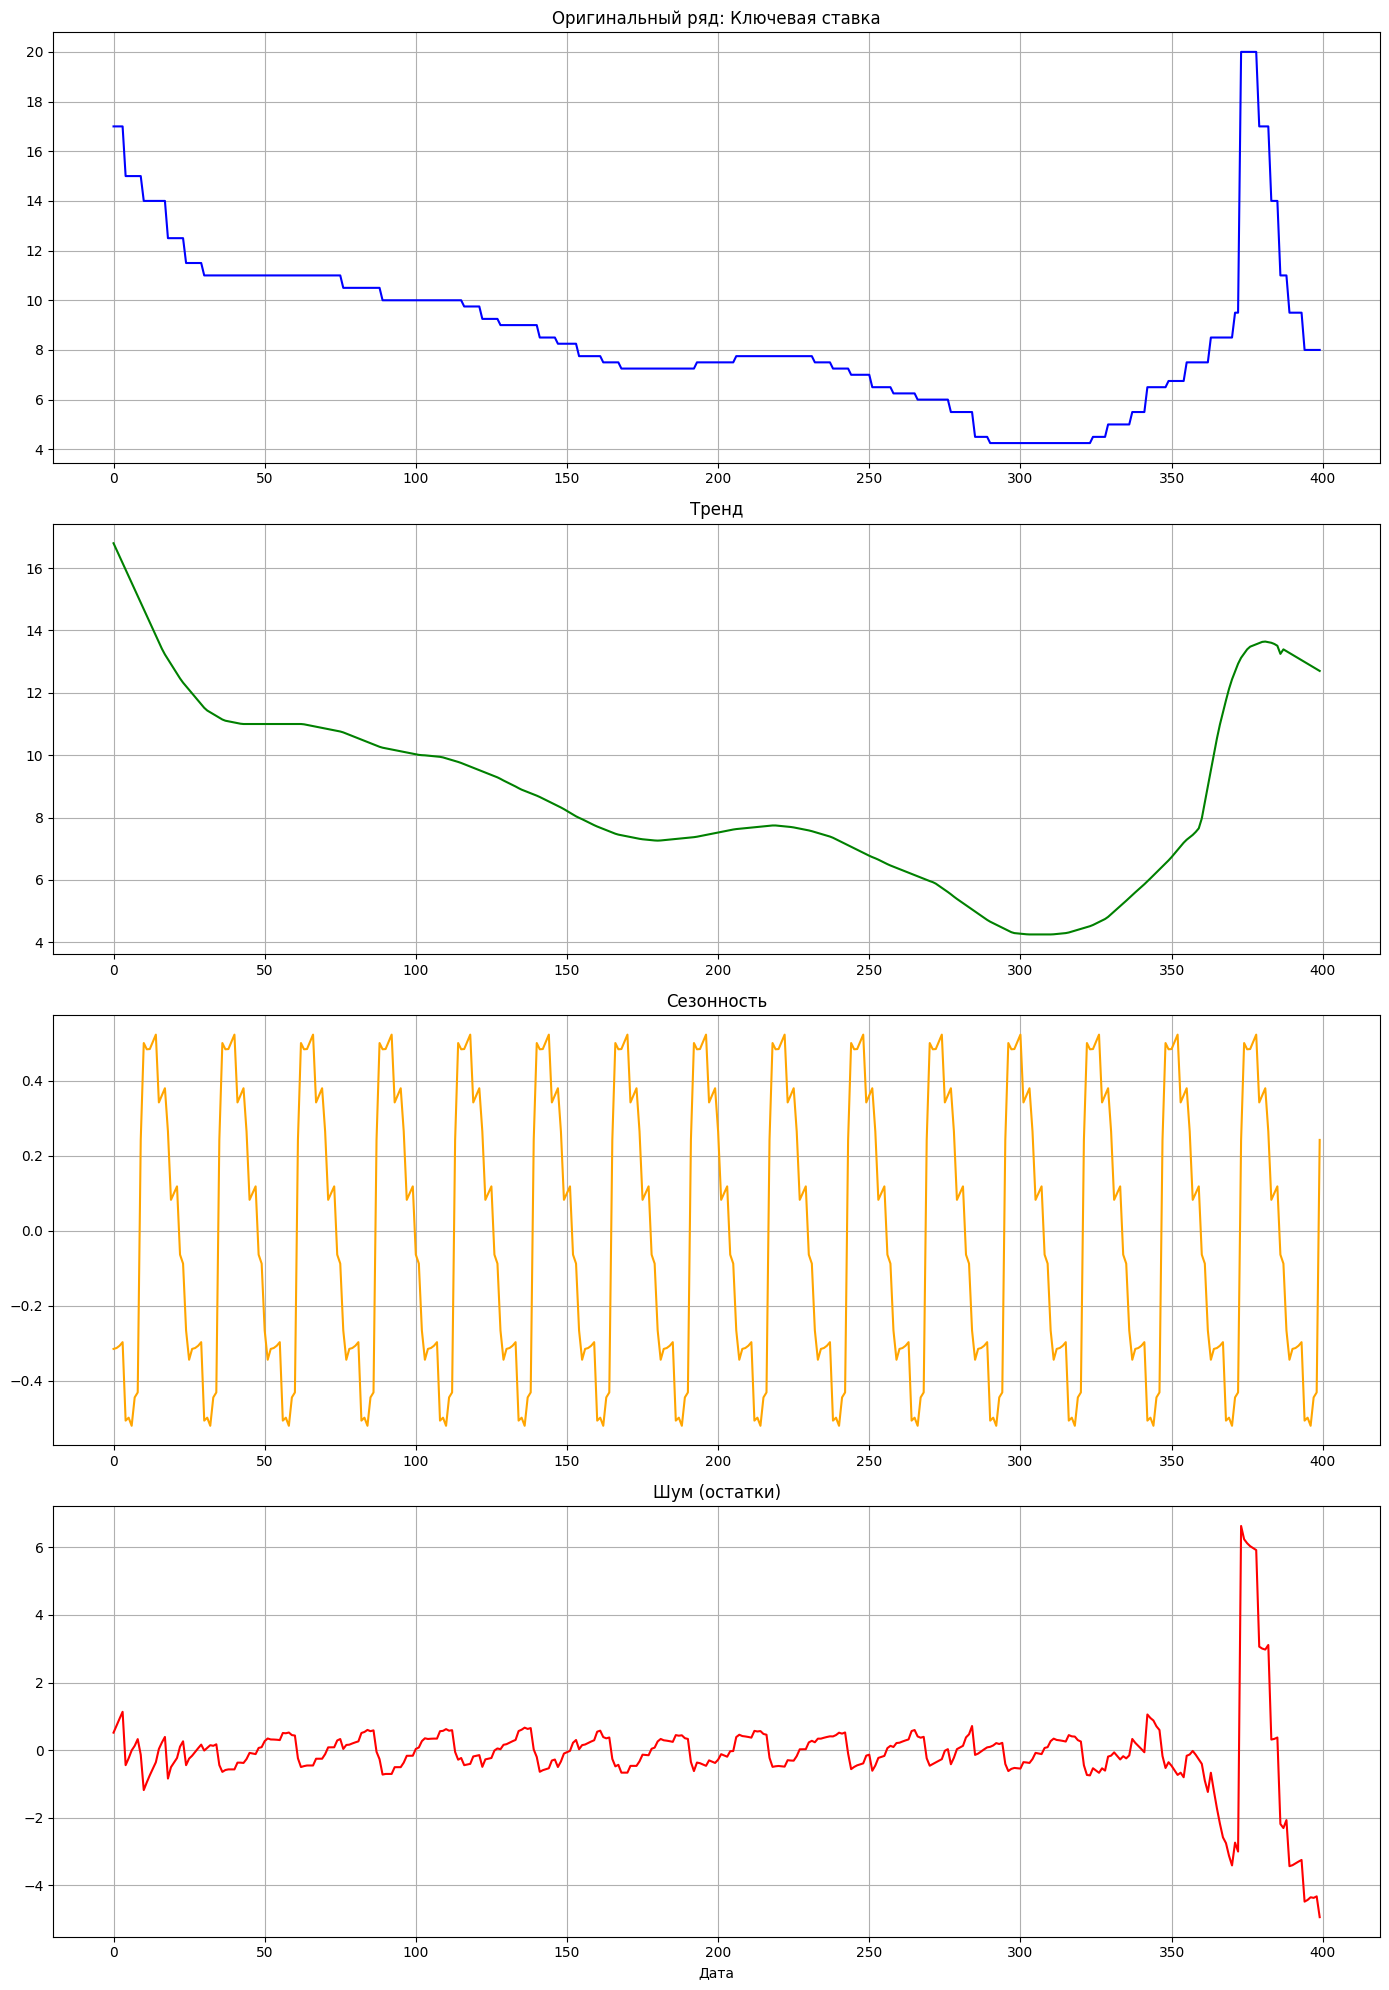

In [18]:
# Визуализация декомпозиции для выбранных переменных
selected_columns = ["Ключевая ставка"]  # Можно менять список
plot_multiple_decompositions(df_ts, selected_columns, period=26)

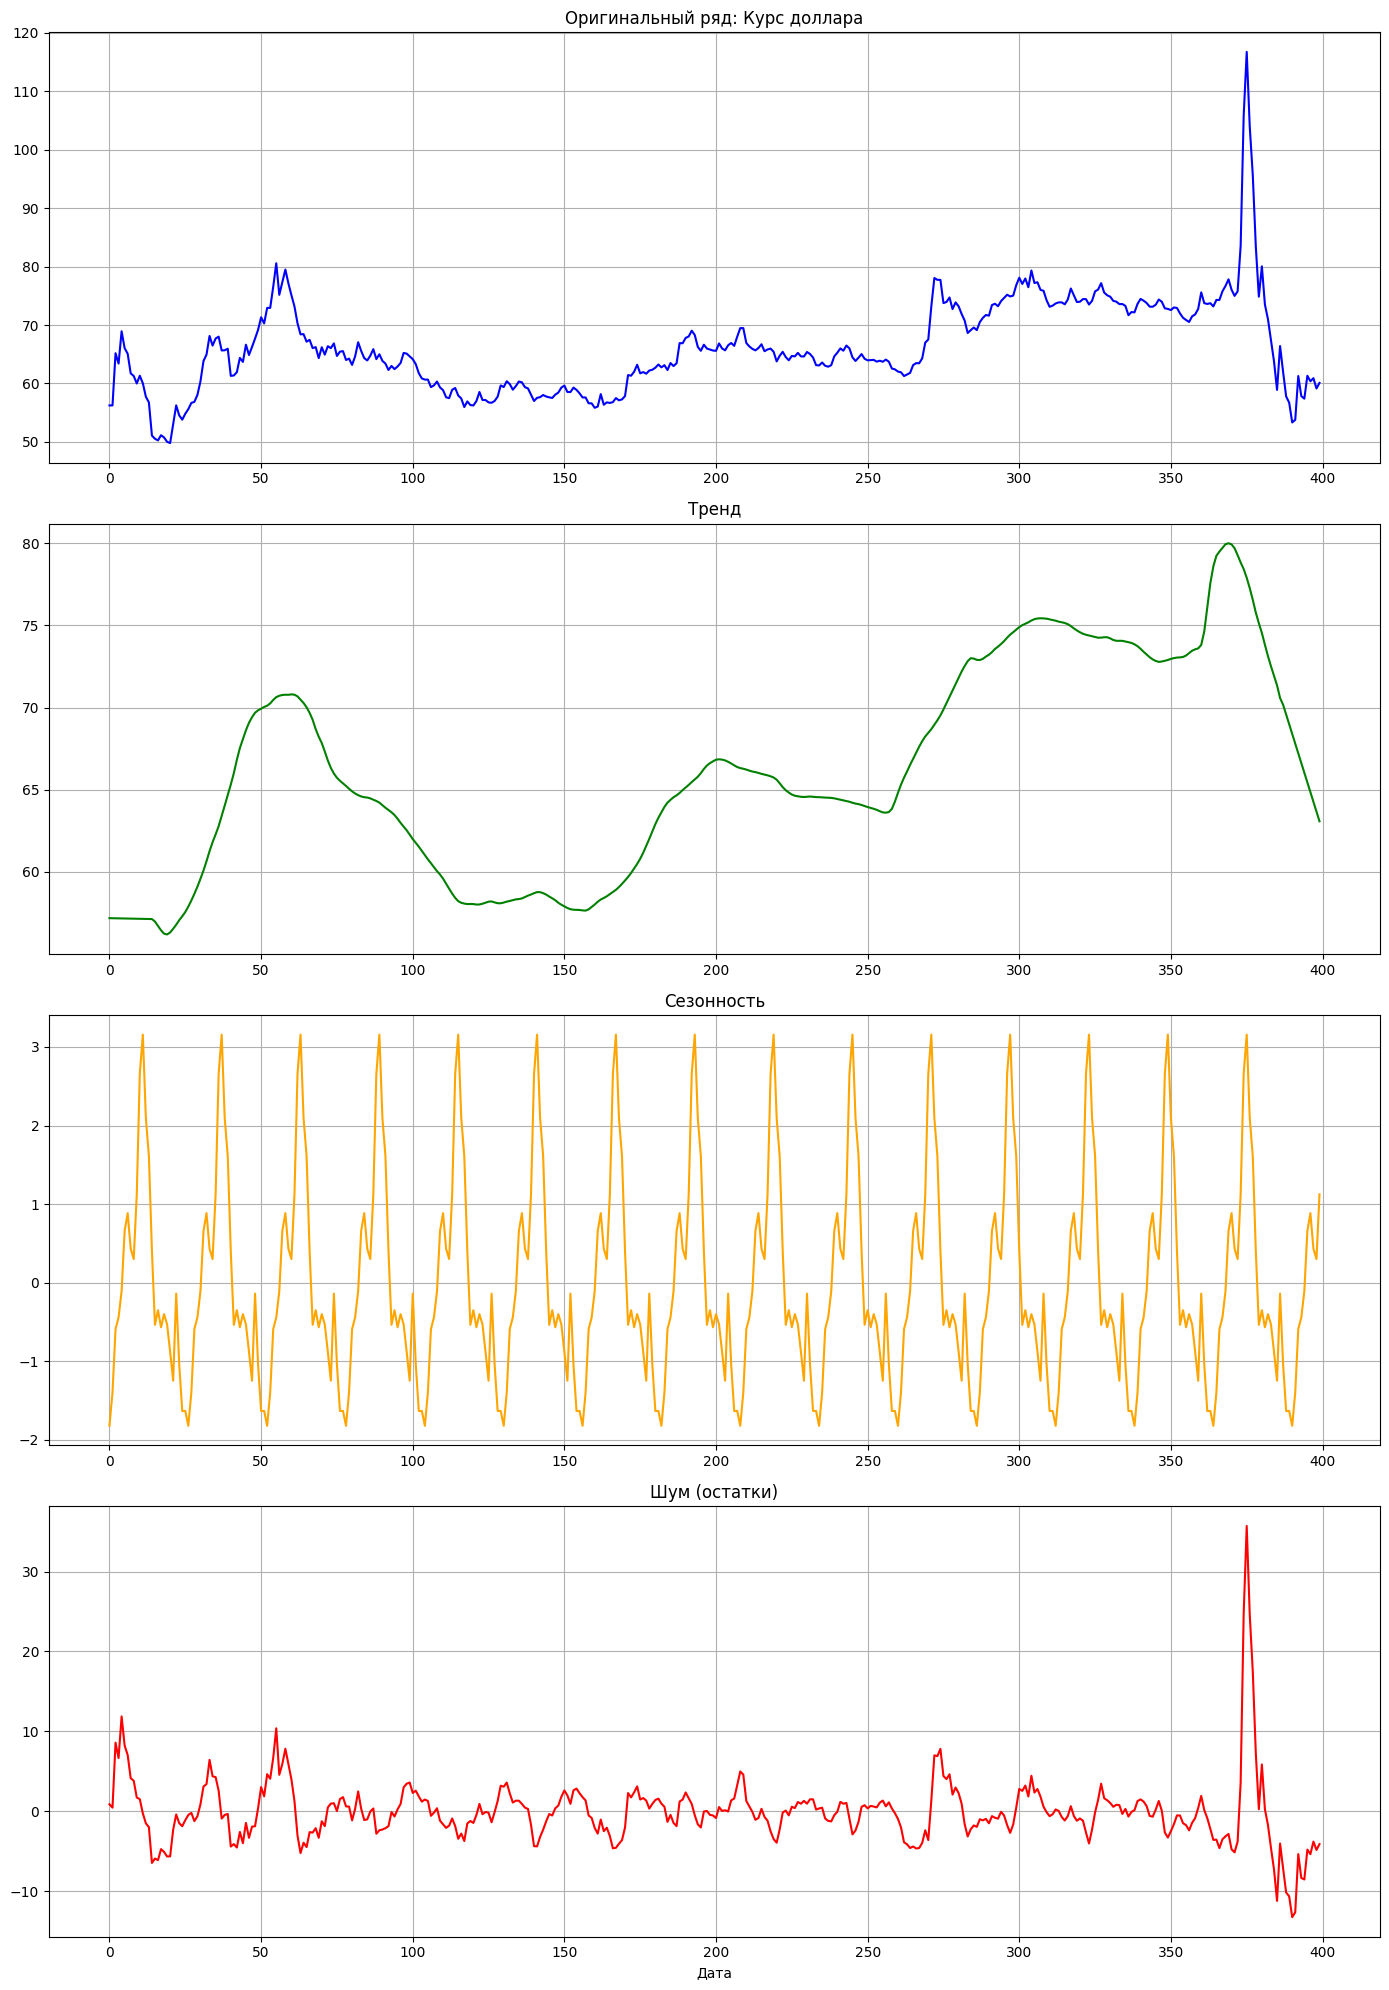

In [19]:
# Визуализация декомпозиции для выбранных переменных
selected_columns = ["Курс доллара"]  # Можно менять список
plot_multiple_decompositions(df_ts, selected_columns, period=26)

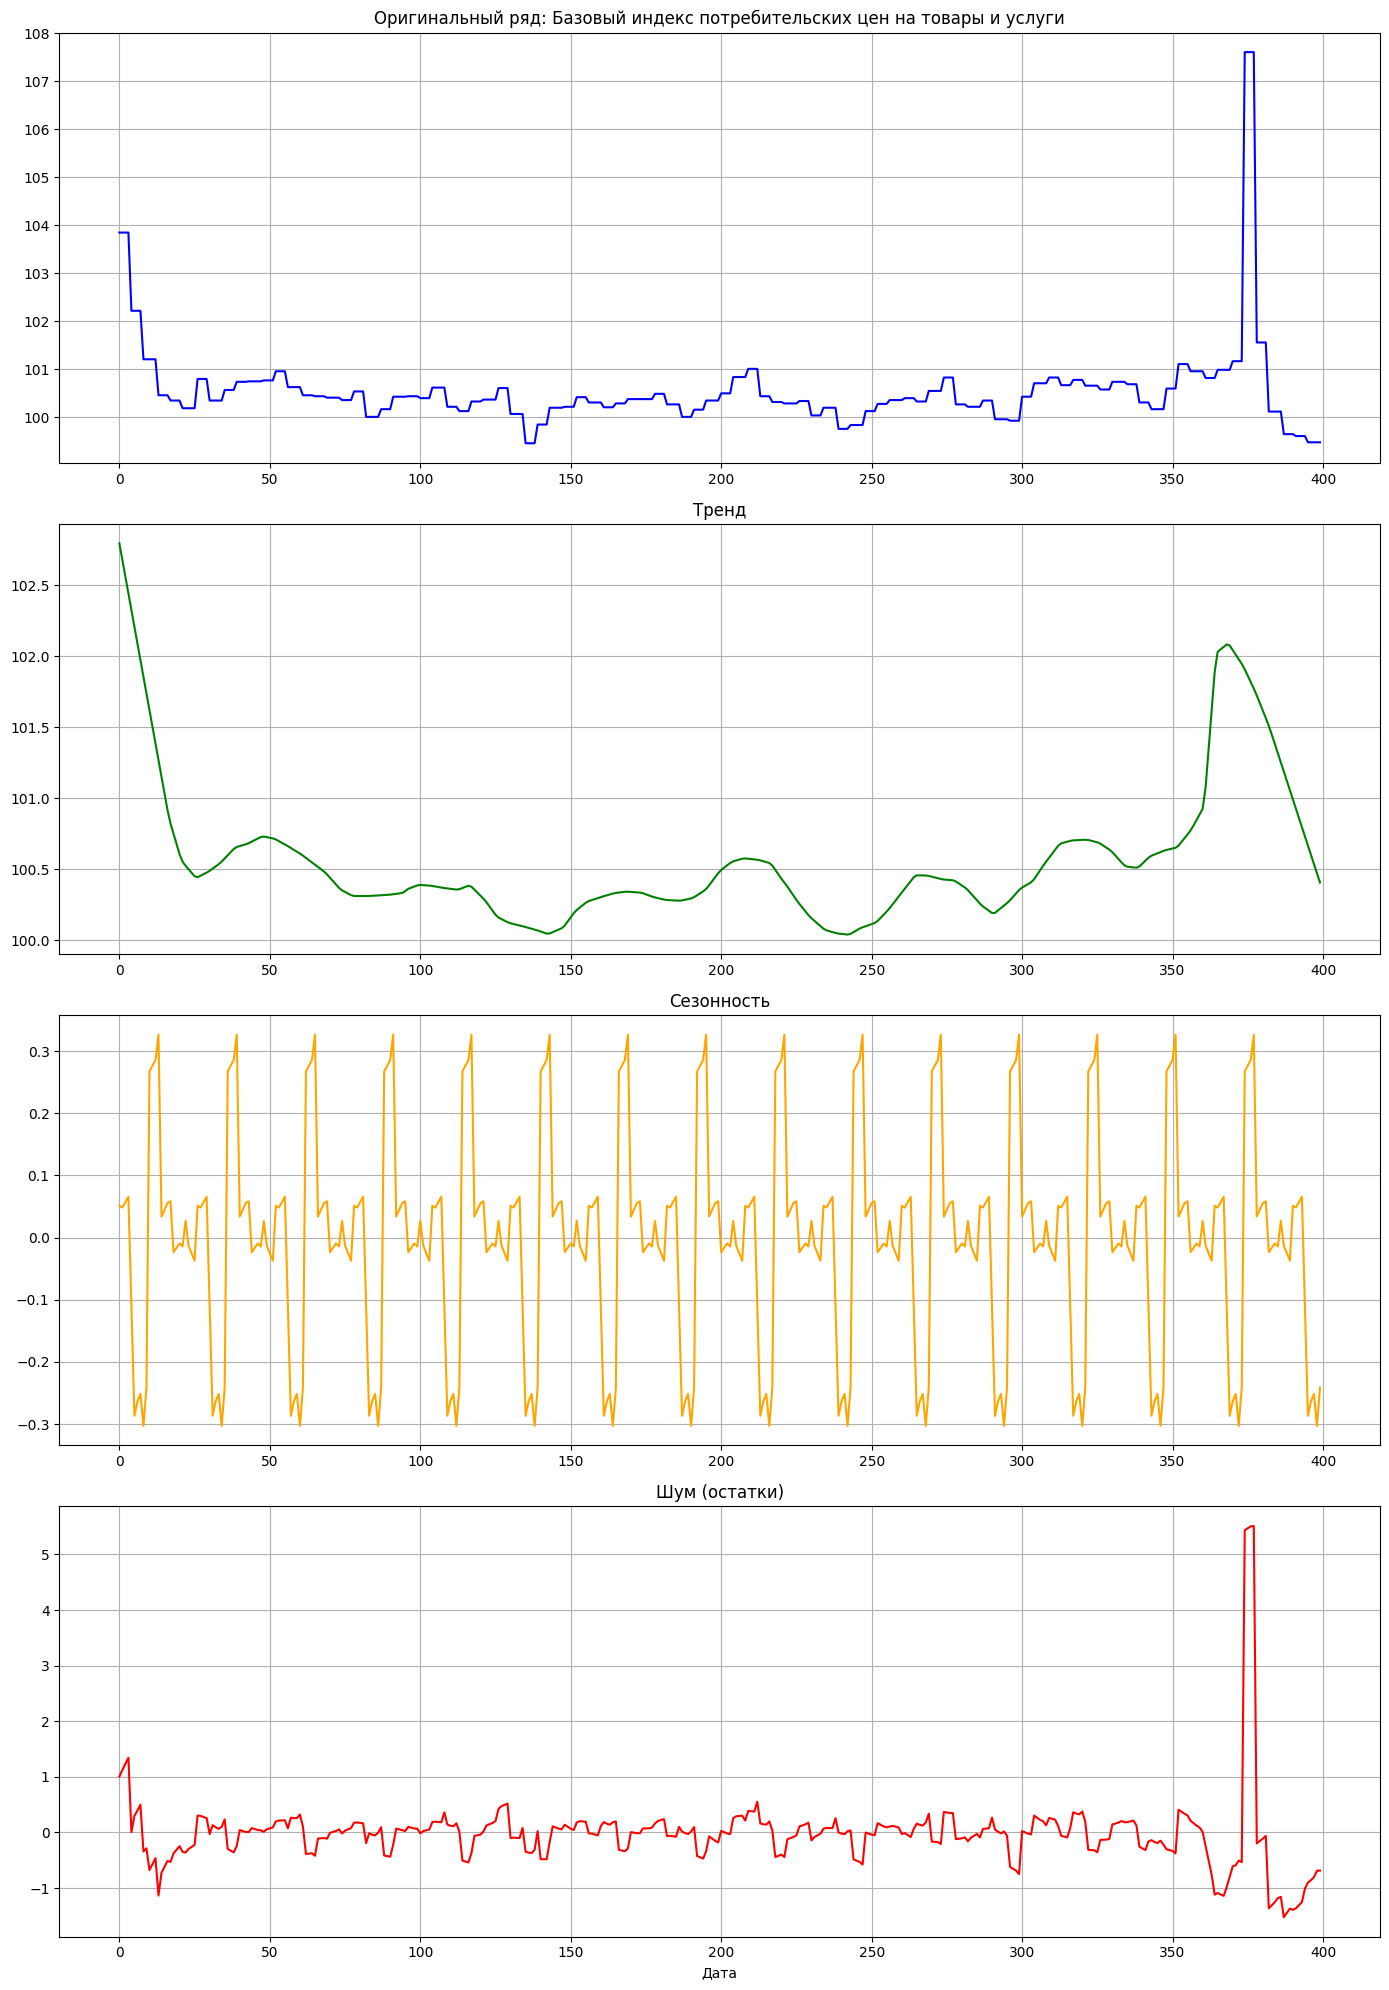

In [20]:
# Визуализация декомпозиции для выбранных переменных
selected_columns = ["Базовый индекс потребительских цен на товары и услуги"]  # Можно менять список
plot_multiple_decompositions(df_ts, selected_columns, period=26)

In [21]:
# проверка на стационарность первоначального ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру'])

ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}
Ряд нестационарен (p-value >= 0.05)


Text(0.5, 1.0, 'Распределение цен на арматуру')

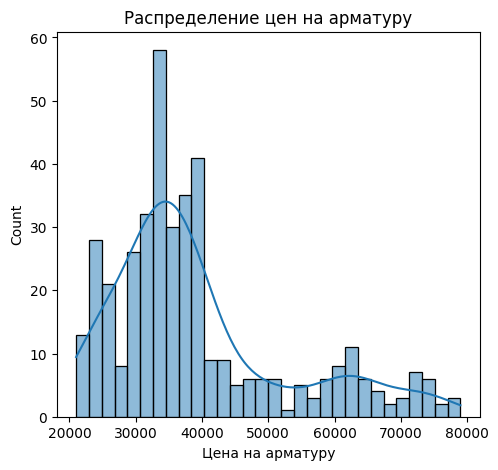

In [22]:
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df_ts["Цена на арматуру"], bins=30, kde=True)
plt.title("Распределение цен на арматуру")


На графики видем что большинство значений  примерно сосредоточено между 30тыс и 40тыс

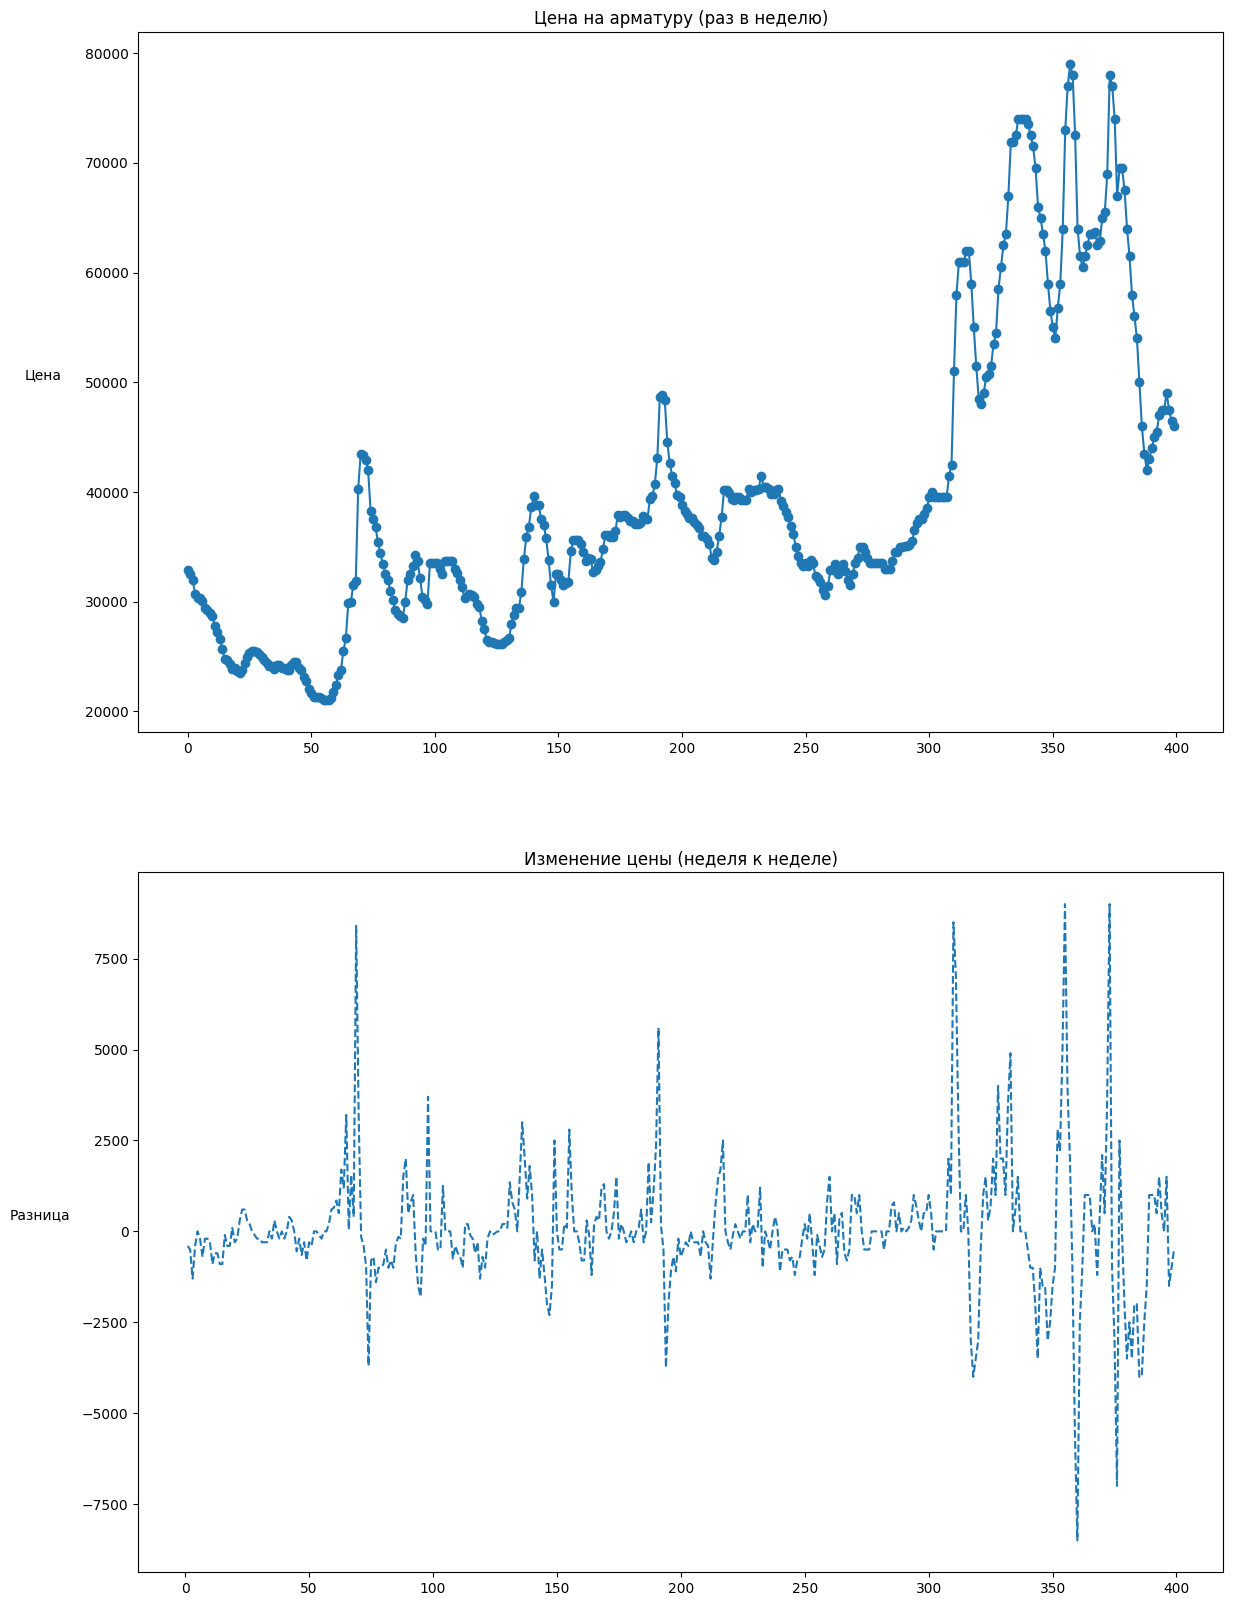

In [23]:
df_ts['Цена_разница_неделя'] = df_ts['Цена на арматуру'].diff(1)  # Разница с прошлой неделей

plt.figure(figsize=(14, 20))

ax1 = plt.subplot(211)
ax1.set_title('Цена на арматуру (раз в неделю)')
ax1.set_ylabel('Цена', rotation=0, labelpad=30)
df_ts['Цена на арматуру'].plot(ax=ax1, marker='o')

ax2 = plt.subplot(212)
ax2.set_title('Изменение цены (неделя к неделе)')
ax2.set_ylabel('Разница', rotation=0, labelpad=30)
df_ts['Цена_разница_неделя'].plot(ax=ax2, marker='', linestyle='dashed')

plt.show()

In [24]:
df_ts.replace(np.nan, 0, inplace=True)

In [25]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 18 columns):
 #   Column                                                          Non-Null Count  Dtype         
---  ------                                                          --------------  -----         
 0   dt                                                              400 non-null    datetime64[ns]
 1   Цена на арматуру                                                400 non-null    int64         
 2   Базовый индекс потребительских цен на товары и услуги           400 non-null    float64       
 3   Ключевая ставка                                                 400 non-null    float64       
 4   Курс доллара                                                    400 non-null    float64       
 5   Цена на арматуру_trend                                          400 non-null    float64       
 6   Цена на арматуру_seasonal                                       400 non-null    float64   

In [26]:
df_ts.head(10)

,dt,Цена на арматуру,Базовый индекс потребительских цен на товары и услуги,Ключевая ставка,Курс доллара,Цена на арматуру_trend,Цена на арматуру_seasonal,Цена на арматуру_residual,Базовый индекс потребительских цен на товары и услуги_trend,Базовый индекс потребительских цен на товары и услуги_seasonal,Базовый индекс потребительских цен на товары и услуги_residual,Ключевая ставка_trend,Ключевая ставка_seasonal,Ключевая ставка_residual,Курс доллара_trend,Курс доллара_seasonal,Курс доллара_residual,Цена_разница_неделя
0,2015-01-05,32900,103.85,17.0,56.2376,30757.692308,424.348434,1717.959258,102.794038,0.051064,1.004898,16.798077,-0.314739,0.516662,57.185106,-1.821811,0.874305,0.0
1,2015-01-12,32500,103.85,17.0,56.2376,30480.769231,501.752281,1517.478489,102.676731,0.048167,1.125102,16.586538,-0.312335,0.725797,57.181225,-1.396052,0.452427,-400.0
2,2015-01-19,32000,103.85,17.0,65.1738,30203.846154,463.771511,1332.382335,102.559423,0.056917,1.233660,16.375000,-0.306326,0.931326,57.177344,-0.591229,8.587685,-500.0
3,2015-01-26,30700,103.85,17.0,63.3930,29926.923077,318.699396,454.377527,102.442115,0.065667,1.342218,16.163462,-0.296710,1.133249,57.173463,-0.441942,6.661479,-1300.0
4,2015-02-02,30300,102.22,15.0,68.9291,29650.000000,-36.012143,686.012143,102.324808,-0.109465,0.004657,15.951923,-0.505845,-0.446078,57.169583,-0.107869,11.867387,-400.0
5,2015-02-09,30300,102.22,15.0,66.0432,29373.076923,-248.848681,1175.771758,102.207500,-0.286749,0.299249,15.740385,-0.498032,-0.242352,57.165702,0.658844,8.218654,0.0
6,2015-02-16,30100,102.22,15.0,65.0862,29096.153846,-456.060219,1459.906373,102.090192,-0.263552,0.393359,15.528846,-0.519667,-0.009179,57.161821,0.884785,7.039594,-200.0
7,2015-02-23,29400,102.22,15.0,61.7235,28819.230769,-683.704450,1264.473681,101.972885,-0.251605,0.498720,15.317308,-0.443946,0.126638,57.157940,0.431402,4.134158,-700.0
8,2015-03-02,29200,101.21,15.0,61.2718,28542.307692,-620.363104,1278.055412,101.855577,-0.302975,-0.342602,15.105769,-0.430725,0.324955,57.154060,0.301278,3.816462,-200.0
9,2015-03-09,29000,101.21,15.0,59.9938,28265.384615,527.713819,206.901566,101.738269,-0.241412,-0.286857,14.894231,0.242352,-0.136583,57.150179,1.124586,1.719035,-200.0


In [27]:
from statsmodels.tsa.stattools import adfuller

# Функция для проверки стационарности
def check_stationarity(series, name):
    result = adfuller(series.dropna())  # Удаляем NaN, если они есть
    print(f"ADF тест для {name}: p-значение = {result[1]:.4f}")
    if result[1] > 0.05:
        print(f"Ряд {name} нестационарен.")
    else:
        print(f"Ряд {name} стационарен.")
    print("---" * 20)  # Добавляем разделитель

# Проверка стационарности для всех колонок
for column in df_ts.columns:
    check_stationarity(df_ts[column], column)

ADF тест для dt: p-значение = 0.9553
Ряд dt нестационарен.
------------------------------------------------------------
ADF тест для Цена на арматуру: p-значение = 0.3200
Ряд Цена на арматуру нестационарен.
------------------------------------------------------------
ADF тест для Базовый индекс потребительских цен на товары и услуги: p-значение = 0.0003
Ряд Базовый индекс потребительских цен на товары и услуги стационарен.
------------------------------------------------------------
ADF тест для Ключевая ставка: p-значение = 0.0956
Ряд Ключевая ставка нестационарен.
------------------------------------------------------------
ADF тест для Курс доллара: p-значение = 0.0227
Ряд Курс доллара стационарен.
------------------------------------------------------------
ADF тест для Цена на арматуру_trend: p-значение = 0.3811
Ряд Цена на арматуру_trend нестационарен.
------------------------------------------------------------
ADF тест для Цена на арматуру_seasonal: p-значение = 0.0000
Ряд Цена

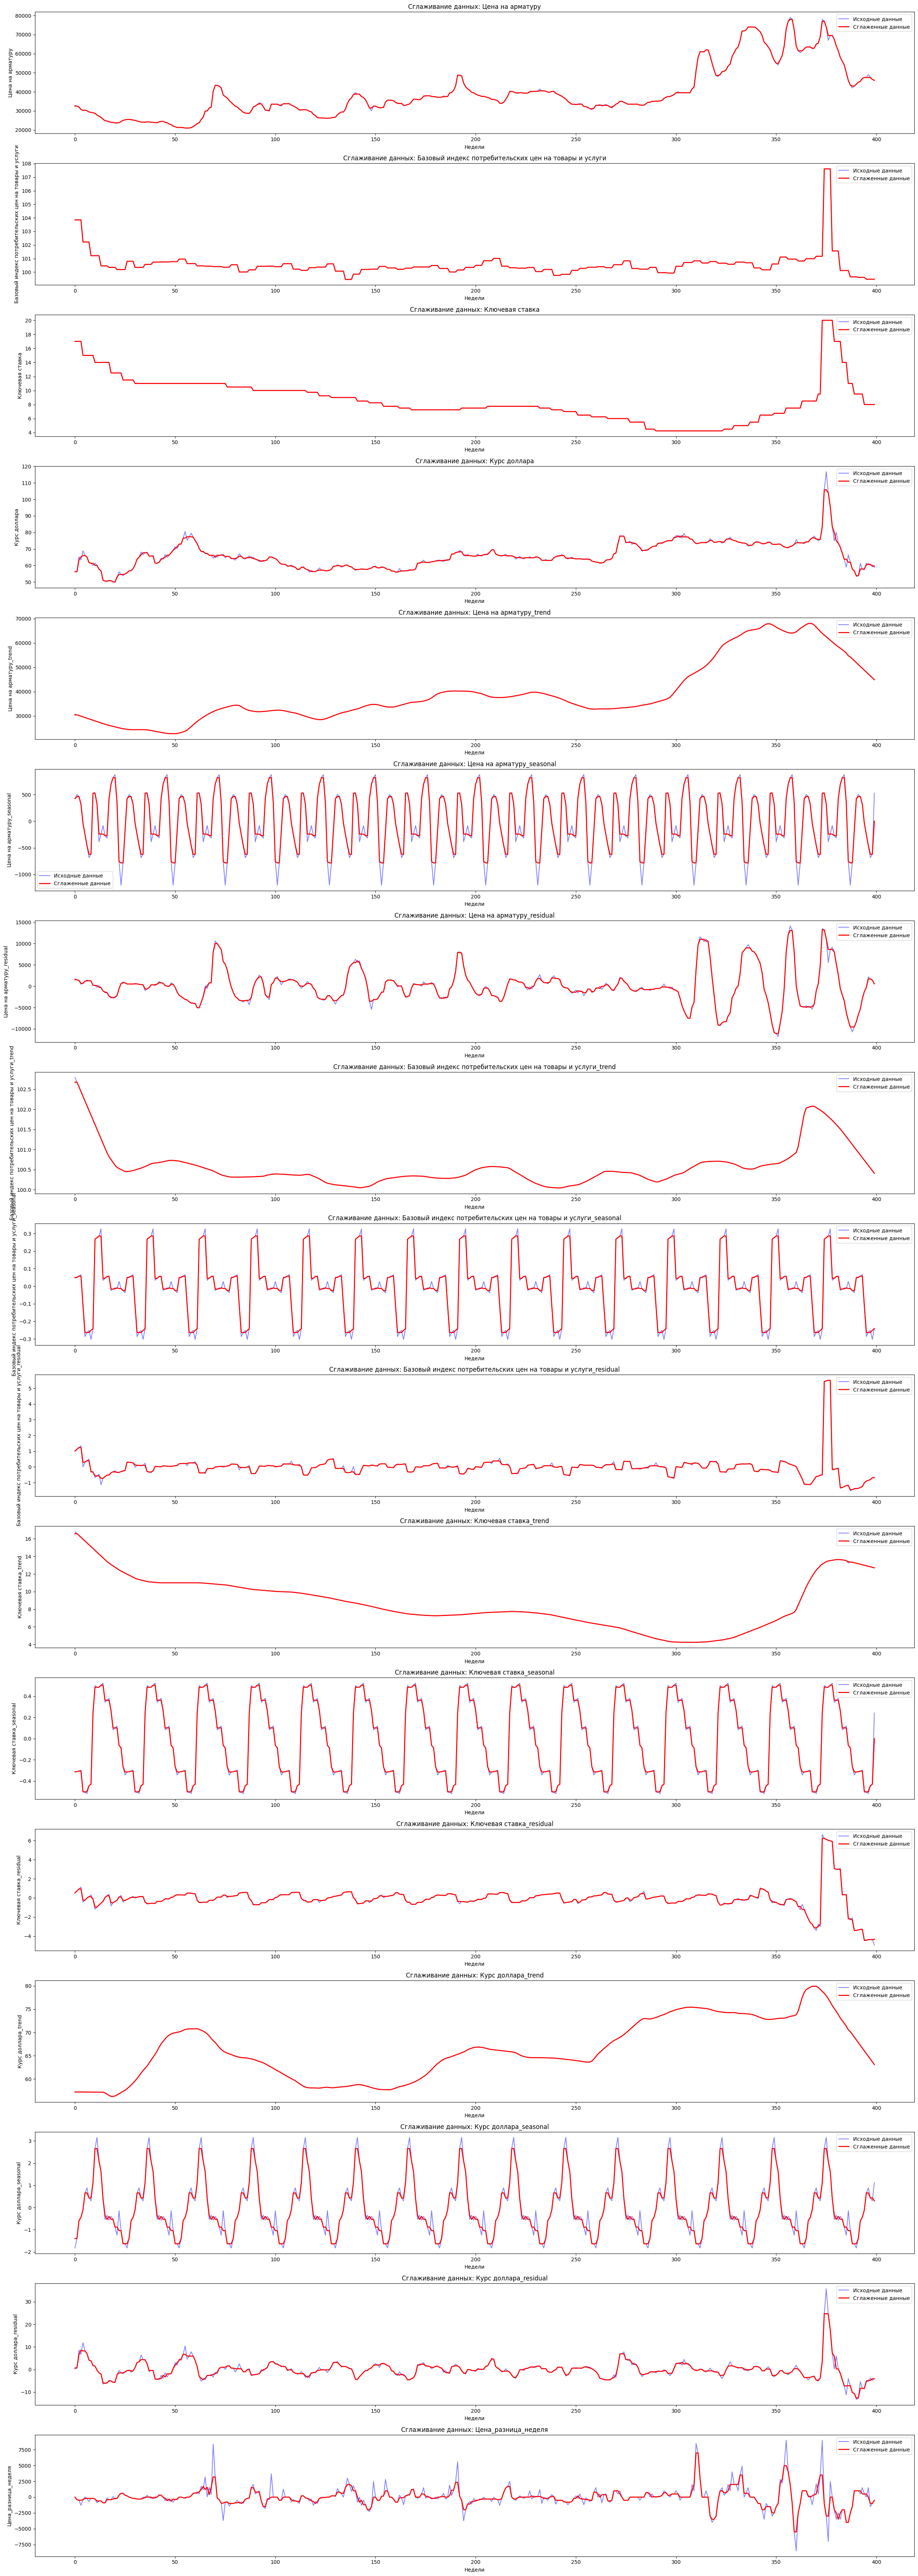

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt


# Создаем копию DataFrame для хранения сглаженных данных
df_smoothed = df_ts.copy()

# Применяем медианный фильтр только к числовым колонкам
for column in df_ts.select_dtypes(include=['number']).columns:  # Выбираем только числовые колонки
    df_smoothed[f"{column}_smoothed"] = medfilt(df_ts[column], kernel_size=3)

# Построение графиков для каждой числовой колонки
plt.figure(figsize=(25, 70))

# Проходим по всем числовым колонкам и строим графики
for i, column in enumerate(df_ts.select_dtypes(include=['number']).columns, 1):
    plt.subplot(len(df_ts.select_dtypes(include=['number']).columns), 1, i)

    # Исходные данные
    plt.plot(df_ts.index, df_ts[column], label="Исходные данные", color='blue', alpha=0.5)

    # Сглаженные данные
    plt.plot(df_smoothed.index, df_smoothed[f"{column}_smoothed"], label="Сглаженные данные", color='red', linewidth=2)

    # Настройка графика
    plt.title(f"Сглаживание данных: {column}")
    plt.xlabel("Недели")
    plt.ylabel(column)
    plt.legend()

plt.tight_layout()
plt.show()

Во все графиках видно как сгладислись данные в колонках для уменьшения количества шумов


# Модели

### GRU

Используемые признаки для X: ['Базовый индекс потребительских цен на товары и услуги_smoothed', 'Ключевая ставка_smoothed', 'Курс доллара_smoothed', 'Цена на арматуру_trend_smoothed', 'Цена на арматуру_seasonal_smoothed', 'Цена на арматуру_residual_smoothed', 'Базовый индекс потребительских цен на товары и услуги_trend_smoothed', 'Базовый индекс потребительских цен на товары и услуги_seasonal_smoothed', 'Базовый индекс потребительских цен на товары и услуги_residual_smoothed', 'Ключевая ставка_trend_smoothed', 'Ключевая ставка_seasonal_smoothed', 'Ключевая ставка_residual_smoothed', 'Курс доллара_trend_smoothed', 'Курс доллара_seasonal_smoothed', 'Курс доллара_residual_smoothed', 'Цена_разница_неделя_smoothed']
Epoch 1/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0732 - val_loss: 0.1484
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0052 - val_loss: 0.0709
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0033 - val_loss: 0.0481
Epoch 4/300
38/38 ━━

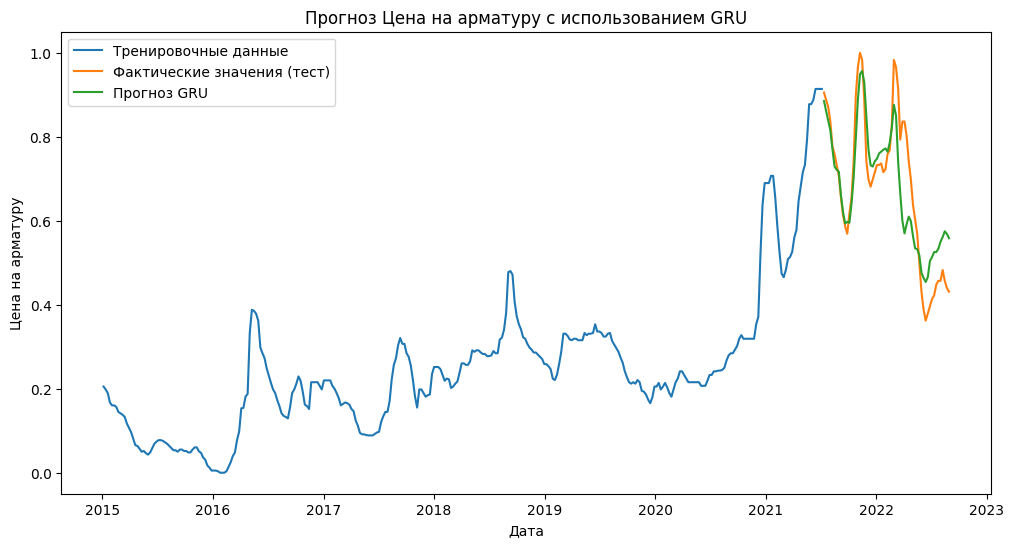

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Определяем целевую переменную
target_column = "Цена на арматуру"

# Выбираем только сглаженные колонки, исключая целевую переменную и её сглаженную версию, но оставляем 'dt' в df_smoothed
feature_columns = [col for col in df_smoothed.columns if col.endswith("_smoothed") and col != target_column and col != f"{target_column}_smoothed"]

# Вывод списка используемых признаков
print("Используемые признаки для X:", feature_columns)

# Нормализация данных (кроме dt)
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

df_smoothed[feature_columns] = scaler_X.fit_transform(df_smoothed[feature_columns])
df_smoothed[target_column] = scaler_y.fit_transform(df_smoothed[[target_column]])

# Разделение на train/test, dt остается в df_smoothed
train_size = int(len(df_smoothed) * 0.8)
train_data, test_data = df_smoothed.iloc[:train_size].copy(), df_smoothed.iloc[train_size:].copy()

# Функция для создания последовательностей
def create_sequences(data, seq_length, feature_columns, target_column):
    X, y, dt_values = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][feature_columns].values)
        y.append(data.iloc[i+seq_length][target_column])
        dt_values.append(data.iloc[i+seq_length]["dt"])  # Сохраняем даты для визуализации
    return np.array(X), np.array(y), dt_values

seq_length = 20  # Длина окна

# Формируем обучающие и тестовые данные
X_train, y_train, _ = create_sequences(train_data, seq_length, feature_columns, target_column)
X_test, y_test, dt_test = create_sequences(test_data, seq_length, feature_columns, target_column)

# Изменяем форму данных для GRU
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(feature_columns)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(feature_columns)))

# Создание модели GRU
model = Sequential([
    Bidirectional(GRU(64, return_sequences=True, input_shape=(seq_length, len(feature_columns)))),
    Dropout(0.2),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(1)
])

# Компиляция модели
model.compile(optimizer='adam', loss='mse')

# Ранняя остановка
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Обучение модели
history = model.fit(X_train, y_train, epochs=300, batch_size=8,
                    validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

# Предсказания
y_pred = model.predict(X_test)

# Обратное масштабирование целевой переменной
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

# Вычисление метрик
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
smape = np.mean(2 * np.abs(y_test_inv - y_pred_inv) / (np.abs(y_test_inv) + np.abs(y_pred_inv))) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Вывод метрик
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Симметричная MAPE (SMAPE): {smape:.2f}%")
print(f"Коэффициент детерминации (R^2): {r2:.4f}")

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(df_smoothed['dt'][:train_size + seq_length],
         scaler_y.inverse_transform(df_smoothed[[target_column]])[:train_size + seq_length],
         label="Тренировочные данные")
plt.plot(dt_test, y_test_inv, label="Фактические значения (тест)")
plt.plot(dt_test, y_pred_inv, label="Прогноз GRU")
plt.xlabel("Дата")
plt.ylabel(target_column)
plt.title(f"Прогноз {target_column} с использованием GRU")
plt.legend()
plt.show()
# 28

Введите дату в формате YYYY-MM-DD: 2022-07-09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Прогноз на 6 недель вперед от 2022-07-09:
2022-07-18: 0.53 рублей за тонну
2022-07-25: 0.51 рублей за тонну
2022-08-01: 0.48 рублей за тонну
2022-08-08: 0.45 рублей за тонну
2022-08-15: 0.41 рублей за тонну
2022-08-22: 0.37 рублей за тонну


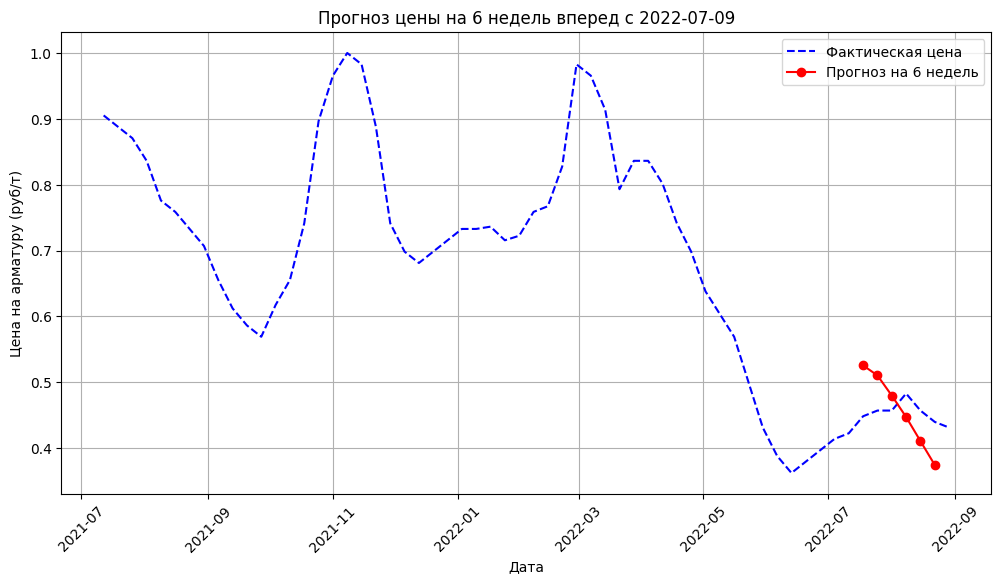

In [33]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# Функция прогнозирования на 6 недель вперед
def predict_next_6_weeks(start_date):
    start_date = pd.to_datetime(start_date)

    # Найти ближайшую дату в тестовом наборе
    closest_date = min(dt_test, key=lambda d: abs(d - start_date))
    date_index = dt_test.index(closest_date)

    # Инициализируем список прогнозов
    predictions = []
    dates = []

    # Прогнозируем последовательно на 6 недель вперед
    current_input = X_test[date_index].reshape(1, seq_length, len(feature_columns))

    for i in range(6):
        pred_price = model.predict(current_input)[0][0]
        pred_price_inv = scaler_y.inverse_transform([[pred_price]])[0][0]

        predictions.append(pred_price_inv)
        dates.append(closest_date + pd.Timedelta(weeks=i+1))

        # Обновляем входные данные, сдвигая окно
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, :] = pred_price

    return dates, predictions

# Запрос даты от пользователя
user_input_date = input("Введите дату в формате YYYY-MM-DD: ")

try:
    forecast_dates, forecast_prices = predict_next_6_weeks(user_input_date)

    print(f"\nПрогноз на 6 недель вперед от {user_input_date}:")
    for date, price in zip(forecast_dates, forecast_prices):
        print(f"{date.strftime('%Y-%m-%d')}: {round(price, 2)} рублей за тонну")

    # Построение графика
    plt.figure(figsize=(12, 6))

    # Фактические данные
    plt.plot(dt_test, y_test_inv, label="Фактическая цена", color="blue", linestyle="dashed")

    # Прогнозируемые цены
    plt.plot(forecast_dates, forecast_prices, label="Прогноз на 6 недель", color="red", marker="o")

    # Оформление графика
    plt.xlabel("Дата")
    plt.ylabel("Цена на арматуру (руб/т)")
    plt.title(f"Прогноз цены на 6 недель вперед с {user_input_date}")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    # Показываем график
    plt.show()

except Exception as e:
    print("Ошибка! Убедитесь, что дата находится в пределах тестового набора данных.")